## Imports

In [1]:
# referenced https://srush.github.io/annotated-s4/#part-1b-addressing-long-range-dependencies-with-hippo

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import fftconvolve

## Quilee test SSSM

In [33]:
class SSM(torch.nn.Module):
    """State Space Model.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
    
    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (batch, seq_len, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, decode=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # SSM parameters
        self.A = torch.nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.A.weight = torch.nn.Parameter(self.make_HiPPO(self.hidden_size), requires_grad=False)
        self.B = torch.nn.Linear(self.input_size, self.hidden_size, bias=False)
        self.step = torch.nn.Parameter(torch.ones(1, hidden_size))
        
    def discretize(self):
        I = torch.eye(self.hidden_size)
        BL = torch.linalg.inv(I - (self.step / 2.0) * self.A.weight)
        Ab = BL @ (I + (self.step / 2.0) * self.A.weight)
        Bb = (BL * self.step) @ self.B.weight
        self.A.weight.data = Ab
        self.B.weight.data = Bb
        return None

    def make_HiPPO(self, N):
        P = torch.sqrt(1 + 2 * torch.arange(N))
        A = P.unsqueeze(-1) @ P.unsqueeze(0)
        A = torch.tril(A) - torch.diag(torch.arange(N))
        return -A

    def init_hidden(self, input_shape):
        device = next(self.parameters()).device
        batch_size = input_shape[0]  # because batch_first=True
        hidden = torch.zeros(batch_size, self.hidden_size).to(device)
        return hidden

    def recurrence(self, input, hidden):
        """
        Run network for one time step.

        Inputs:
            input: tensor of shape (batch_size, input_size)
            hidden: tensor of shape (batch_size, hidden_size)

        Outputs:
            h_new: tensor of shape (batch_size, hidden_size),
                network activity at the next time step
        """
        h_new = self.A(hidden) + self.B(input)
        return h_new
    
    def K_conv(self, Ab, Bb, L):
        """Computes the kernels for the convolutional mode of the SSM.
        Ab and Bb are the discretized SSM parameter matrices. L is the sequence length.
        
        We create an independent kernel for each state dimension.
        Each element of Kernels is a tensor of shape (hidden_size, input_size).
        So Kernels should have shape (hidden_size, L, input_size).
        """
        assert Ab.shape == (self.hidden_size, self.hidden_size) and Bb.shape == (self.hidden_size, self.input_size), "SSM parameters are not of the right shape."
        Kernels = torch.stack([(torch.matrix_power(Ab, l) @ Bb) for l in range(L)]).permute((1,0,-1))
        return Kernels

    def causal_convolution(self, u, Kernels):
        """
        u is the input tensor with shape (seq_len, input_size).
        Kernels is hidden_size independent kernels of shape (seq_len, input_size).
        ouputs should be a tensor with shape (seq_len, hidden_size).
        """
        assert Kernels.shape[0] == self.hidden_size and Kernels.shape[-1] == self.input_size, "Kernels do not have the right shape."
        seq_len = u.shape[0]
        outputs = []
        for K in Kernels: # O(hidden_size) operations
            u_padded = torch.nn.functional.pad(u, (0, 0, 0, K.shape[0]))
            K_padded = torch.nn.functional.pad(K, (0, 0, 0, seq_len))
            ud = torch.fft.rfft(u_padded, dim=0) # (seq_len, input_size)
            Kd = torch.fft.rfft(K_padded, dim=0) # (seq_len, input_size)
            out = torch.fft.irfft(ud * Kd, dim=0)[:seq_len].sum(dim=-1) # (seq_len,)
            outputs.append(out) # (hidden_size, seq_len)
        outputs = torch.stack(outputs).t() # (seq_len, hidden_size)
        return outputs

    def forward(self, input, hidden=None, decode=False):
        """
        Propagate input through the network. NOTE: Because we use
        batch_first=True, input has shape (batch_size, seq_len, input_size).

        decode: Whether to use recurrence (True) or convolution (False) to propagate input.
        """
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape)
        # Discretize the SSM parameters
        self.discretize()
        ### DEBUG ###
        # Run the SSM
        if not decode: # CNN mode
            Kernels = self.K_conv(self.A.weight, self.B.weight, input.size(1))
            batch_size = input.size(0)
            output = []
            # Loop over batch
            for b in range(batch_size):
                out = self.causal_convolution(input[b], Kernels) # (seq_len, hidden_size)
                output.append(out)
            # Stack together output from all batch elements
            output = torch.stack(output, dim=0) # (batch_size, seq_len, hidden_size)
        ### DEBUG ###
        else: # RNN mode
            seq_len = input.size(1)
            output = []
            # Loop through time
            for i in range(seq_len):
                # `hidden` is just the most recent state
                hidden = self.recurrence(input[:, i, :], hidden) # (batch_size, hidden_size)
                output.append(hidden)
            # Stack together output from all time steps
            output = torch.stack(output, dim=1)  # (batch_size, seq_len, hidden_size)
        return output, hidden
    

Input signal shape: torch.Size([2, 10, 8])
Output signal shape: torch.Size([2, 10, 50])



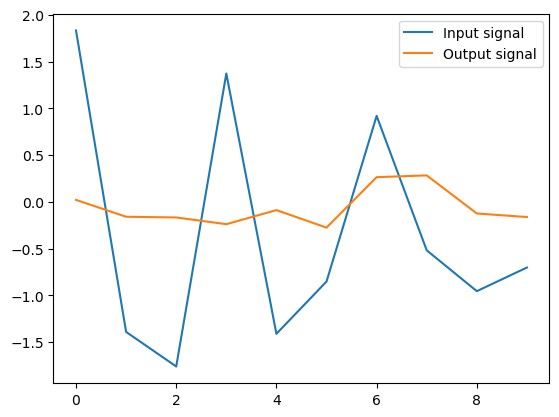

In [34]:
model_dim = 50
timesteps = 10
num_channels = 8
batch_size = 2

# test 1
model = SSM(input_size=num_channels, hidden_size=model_dim)

input_signal = torch.randn((batch_size, timesteps, num_channels))
print(f'Input signal shape: {input_signal.shape}')

output_signal, hidden_state = model(input_signal)
print(f'Output signal shape: {output_signal.shape}\n')


plt.plot(input_signal[0, :, 0], label='Input signal')
plt.plot(output_signal[0, :, 0].detach().cpu(), label='Output signal')
plt.legend()

## Mass example

In [35]:
def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]])
    B = torch.tensor([[0], [1.0 / m]])
    C = torch.tensor([[1.0, 0]])
    
    return A, B, C

def example_force(t):
    x = torch.sin(10 * t)
    return x * (x > 0.5)

Input signal shape: torch.Size([1, 100, 1])
Output signal shape: torch.Size([1, 100, 2])


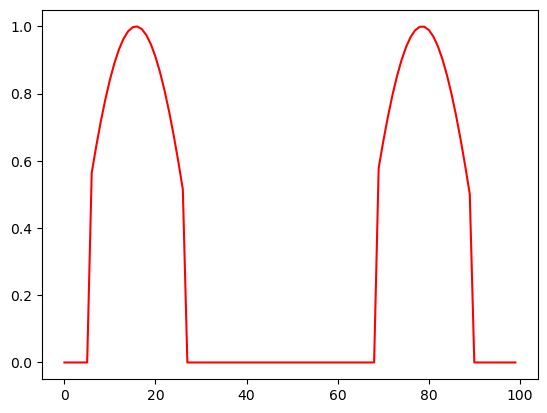

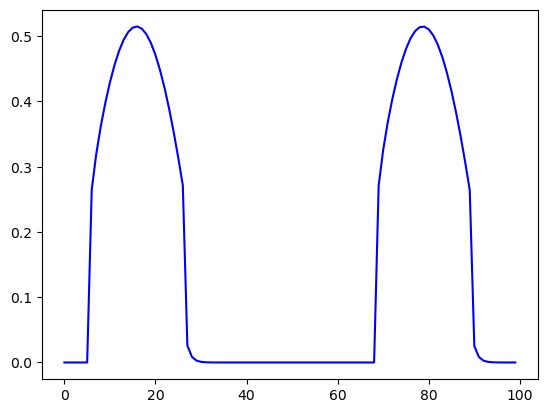

In [37]:
A, B, C = example_mass(k=40, b=5, m=1)

seq_len = 100
step = 1.0 / seq_len
ks = torch.arange(seq_len)
u = example_force(ks * step)

# Approximation of y(t).
model = SSM(input_size=1, hidden_size=2)

input_signal = u.view(1, -1, 1)
print(f'Input signal shape: {input_signal.shape}')

output_signal, hidden_state = model(input_signal)
print(f'Output signal shape: {output_signal.shape}')


plt.figure()
plt.plot(ks, input_signal.view(-1).numpy(), color="red")
plt.figure()
plt.plot(ks, output_signal[0,:,-1].view(-1).detach().numpy(), color="blue")